In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import drivers
from importlib import  reload
from lib import data_management as dm

In [3]:
# reload(drivers.Agilent_EXA)
from drivers.Agilent_EXA import *
# reload(drivers.KeysightAWG)
from drivers.KeysightAWG import *
from drivers.E8257D import E8257D
from scipy.fftpack import fft, fftshift

In [4]:
awg = KeysightAWG("AWG2")

In [33]:
calibrations=(dm.load_IQMX_calibration_database("TEST", -20))
cal = calibrations.get(frozenset(dict(lo_power=10, ssb_power=-20, lo_frequency=7e9, 
                                      if_frequency=10e6, waveform_resolution=0.1).items()))
print(cal)

Calibration data for mixer TEST
Mixer parameters: {'mixer_id': 'TEST', 'iq_attenuation': -20}
Radiation parameters: {'waveform_resolution': 0.1, 'if_frequency': 10000000.0, 'lo_frequency': 7000000000.0, 'lo_power': 10, 'ssb_power': -20}
Optimization results: {'dc': -85.744186401367188, 'if': [-19.944990158081055, -83.9659423828125, -104.69873809814453]}
Optimization parameters {'if_phase': array([ 1.58753583]), 'dc_offsets': array([-0.2171467 ,  0.03779126]), 'if_amplitudes': array([ 1.08774103,  1.10904942]), 'if_offsets': array([-0.21710412,  0.04083596])}
Optimization time: 0 h 0 m 42.73 s
Finished at: 2016-12-27 19:30:16.686737


In [34]:
pb = PulseBuilder(cal)

In [37]:
pulse = pb.add_sine_pulse(1000, 0).modulate_gauss(0.5,20).add_zero_pulse(100)\
                .add_sine_pulse(50, pi/2).modulate_rectangle(0.3).add_zero_pulse(100).build()
for i in range(1):
#     pb = pb.add_sine_pulse(1000,0).add_zero_pulse(1000)
#     pb = pb.add_sine_pulse(1000,0).modulate_hamming().add_zero_pulse(1000)
#     pb = pb.add_sine_pulse(1000,0).modulate_gauss(1, 250).add_zero_pulse(1000)
#      pb = pb.add_sine_pulse(1000,0).modulate_chebwin(100).add_zero_pulse(1000)
      pb = pb.add_sine_pulse(100,0)

pulse = pb.build()

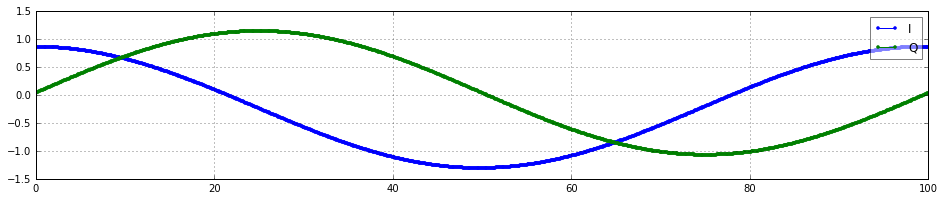

In [38]:
pulse.plot(marker=".")
plt.legend(framealpha=0.5)
plt.grid()
plt.gcf().set_size_inches(16,3)
# plt.xlim(0,10)

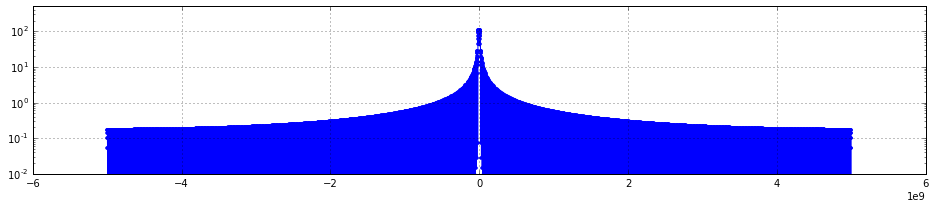

In [39]:
N = len(pulse.get_I_waveform())*10
plot(fftshift(fftfreq(N, 0.1e-9)), abs(fftshift(fft(pulse.get_I_waveform(), n=N))), marker=".")
# plt.xlim(0e6,200e6)
plt.yscale("log")
plt.ylim(1e-2, 5e2)
plt.gcf().set_size_inches(16,3)
plt.grid()

In [40]:
awg.output_pulse_sequence(pulse)

In [ ]:
awg.load_arbitrary_waveform_to_volatile_memory(pulse.get_I_waveform()[:])

In [ ]:
awg.set_outp1(1)

In [19]:
ifo1, ifo2 = cal.get_optimization_results()[0]["if_offsets"]
am1, am2 = cal.get_optimization_results()[0]["if_amplitudes"]
phase = cal.get_optimization_results()[0]["if_phase"]

awg.output_continuous_wave(frequency=100e6, amplitude=am1, phase=phase, offset=ifo1, waveform_resolution=0.5, channel=1)
awg.output_continuous_wave(frequency=100e6, amplitude=am2, phase=0, offset=ifo2,  waveform_resolution=0.5, channel=2)

In [ ]:
awg.output_continuous_wave(frequency=100e6, amplitude=1, phase=0, offset=0, channel=1)
awg.output_continuous_wave(frequency=100e6, amplitude=1, phase=0, offset=0, channel=2)

In [12]:
exa = Agilent_EXA_N9010A("EXA", "EXA")

In [14]:
exa.setup_swept_sa(7e9, 500e6, 1001, 1e4)

In [ ]:
exa.set_continuous(True)

In [ ]:
exa.sweep_single()

In [ ]:
result_no_cal = exa.get_tracedata()

In [ ]:
rect=exa.get_tracedata()

In [ ]:
hamming = exa.get_tracedata()

In [ ]:
gauss = exa.get_tracedata()

In [ ]:
chebwin = exa.get_tracedata()

In [ ]:
wins = [rect, hamming, gauss, chebwin]
labels = ["Rectangular", "Hamming", "Gauss", "Chebwin"]

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,5))
for win, ax, label in zip(wins,axes.ravel(), labels):
    ax.plot(win, label=label)
    ax.legend()
    ax.set_ylim(-90, -10)

In [ ]:
plots = [result, result20, result_no_cal]
labels = ['-40 dBm ssb', '-20 dBm ssb', 'no cal']

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,5))
for win, ax, label in zip(plots,axes.ravel(), labels):
    ax.plot(win, label=label)
    ax.legend()
    ax.set_ylim(-90, -10)

In [ ]:
awg.